# Chapter 5 Code


We will use the following imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

## The Optimal Savings Problem

First we set parameters and construct the state and action spaces.

In [2]:
beta, rho = 0.5, 0.9
z_bar, s_bar = 10, 5

S = np.arange(z_bar + s_bar + 1)    # State space = 0,...,z_bar + s_bar
Z = np.arange(z_bar + 1)            # Shock space = 0,...,z_bar 

Next we write down the primitives of the problem, such as the utility function.

In [3]:
def U(c):      
    "Utility function."
    return c**beta

def phi(z):    
    "Probability mass function, uniform distribution."
    return 1.0 / len(Z) if 0 <= z <= z_bar else 0

def Gamma(x):  
    "The correspondence of feasible actions."
    return range(min(x, s_bar) + 1)

### Value Function Iteration

To implement VFI, we first construct the Bellman operator $T$.

In [4]:
def T(v):      
    Tv = np.empty_like(v)
    for x in S:
        # Compute the value of the objective function for each 
        # a in Gamma(x) and record highest value.
        running_max = -np.inf
        for a in Gamma(x):
            y = U(x - a) + rho * sum(v[a + z]*phi(z) for z in Z)
            if y > running_max:
                running_max = y
        # Store the maximum reward for this x in Tv
        Tv[x] = running_max
    return Tv 

The next function computes a $w$-greedy policy.

In [5]:
def get_greedy(w):      
    sigma = np.empty_like(w)
    for x in S:
        running_max = -np.inf
        for a in Gamma(x):
            y = U(x - a) + rho * sum(w[a + z]*phi(z) for z in Z)
            # Record the action that gives highest value
            if y > running_max:
                running_max = y
                sigma[x] = a
    return sigma

The following function implements value function iteration, starting with the
utility function as the initial condition.

Iteration continues until the sup deviation between iterates is less than
`tol`.

In [6]:
def compute_value_function(tol=1e-4,
                           max_iter=1000,
                           verbose=True,
                           print_skip=5):

    # Set up loop
    v = [U(x) for x in S]     # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

Let's run the code and plot the result.

Error at iteration 5 is 1.2573668687016468.
Error at iteration 10 is 0.741211643809562.
Error at iteration 15 is 0.4376689170549888.
Error at iteration 20 is 0.2584390462574362.
Error at iteration 25 is 0.15260567184870055.
Error at iteration 30 is 0.09011212316537609.
Error at iteration 35 is 0.05321030760788403.
Error at iteration 40 is 0.0314201545393793.
Error at iteration 45 is 0.018553287053961753.
Error at iteration 50 is 0.010955530472493535.
Error at iteration 55 is 0.0064691311887052905.
Error at iteration 60 is 0.003819957275620567.
Error at iteration 65 is 0.002255646571679648.
Error at iteration 70 is 0.0013319367441120278.
Error at iteration 75 is 0.0007864953280325437.
Error at iteration 80 is 0.00046441762625448746.
Error at iteration 85 is 0.0002742339641272906.
Error at iteration 90 is 0.00016193241347650655.
Error at iteration 95 is 9.561947083724931e-05.

Converged in 95 iterations.


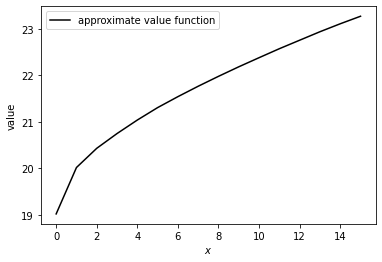

In [7]:
v_star = compute_value_function()

fig, ax = plt.subplots()
ax.plot(S, v_star, 'k-', label='approximate value function')
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("value")

#plt.savefig("vfiv.pdf")

plt.show()


Now we can compute the $v^*$-greedy policy, which is approximately optimal.

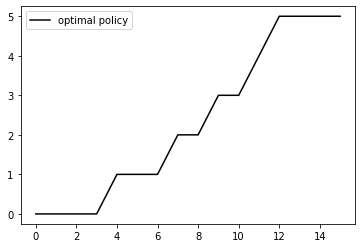

In [8]:
sigma_star = get_greedy(v_star)

fig, ax = plt.subplots()
ax.plot(S, sigma_star, 'k-', label='optimal policy')
ax.legend()

plt.show()


Even though value function iteration only guarantees an approximately optimal
policy, since computation of the value function is only up to a certain degree
of precision, it turns out that our policy is exactly optimal.

This becomes clear in the next section.

Before that, let's check that the Markov chain for wealth is globally stable
by calculating the Dobrushin coefficient.

Here's a function to compute the Dobrushin coefficient.

In [9]:
def dobrushin(p):
    running_min = 1
    for x in S:
        for xp in S:
            a = sum((min(p[x,y], p[xp, y]) for y in S))
            if a < running_min:
                running_min = a
    return running_min

Now we construct the stochastic kernel at the optimal policy and check the
Dobrushin coefficient.

In [10]:
p_sigma = np.empty((len(S), len(S)))

for x in S:
    for y in S:
        p_sigma[x, y] = phi(y - sigma_star[x])

dobrushin(p_sigma)

0.5454545454545455

The Dobrushin coefficient is positive so global stability holds.

We'll borrow some earlier code to compute the stationary distribution.

In [11]:
from numpy.linalg import solve

def compute_stationary(p):
    N = p.shape[0]
    I = np.identity(N)
    O = np.ones((N, N))
    A = I - p + O
    return solve(A.T, np.ones((N, 1))).flatten()


Now let's compute it.

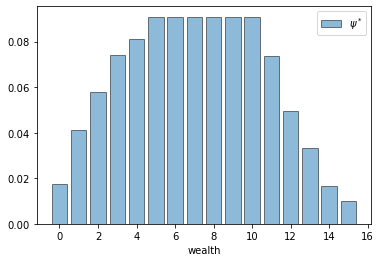

In [12]:
fig, ax = plt.subplots()
psi_star = compute_stationary(p_sigma)

ax.bar(S, psi_star, edgecolor='k', alpha=0.5, label=r'$\psi^*$')
ax.set_xlabel('wealth')
ax.legend()

# plt.savefig("opt_wealth_dist.pdf")

plt.show()

### Policy Iteration

Now we turn to the Howard policy iteration algorithm.

In the finite state setting, this algorithm converges to the exact optimal
policy.

To implement the algorithm, we need to be able to evaluate the lifetime reward
of any given policy.

The next function does this using the algebraic method suggested in the
textbook.

In [13]:
def compute_policy_value(sigma):
    
    # Construct r_sigma and p_sigma = M_sigma
    n = len(S)
    r_sigma = np.empty(n)
    p_sigma = np.empty((n, n))
    for x in S:
        r_sigma[x] = U(x - sigma[x])
        for y in S:
            p_sigma[x, y] = phi(y - sigma[x])


    # Solve sigma = (I - rho p_sigma)^{-1} r_sigma
    I = np.identity(n)
    sigma = np.linalg.solve(I - rho * p_sigma, r_sigma)
    return sigma

Now we can implement policy iteration.

In [14]:
def policy_iteration(max_iter=1e6, verbose=True):

    sigma = np.zeros(len(S))  # Starting point
    i = 1

    while i < max_iter:
        v_sigma = compute_policy_value(sigma)
        new_sigma = get_greedy(v_sigma)
        if np.all(new_sigma == sigma):
            break
        else:
            sigma = new_sigma
            i += 1

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return sigma


Now let's compute using policy iteration and plot.


Converged in 4 iterations.


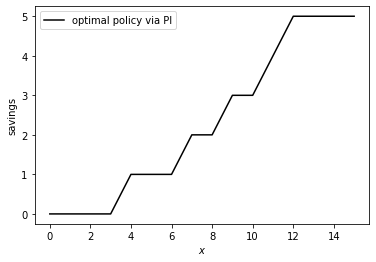

In [15]:
sigma_star_pi = policy_iteration()

fig, ax = plt.subplots()
ax.plot(S, sigma_star_pi, 'k-', label='optimal policy via PI')
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("savings")

# plt.savefig("wealth_opt_pol.pdf")

plt.show()


Let's check that the two ways of computing the optimal policy are
equivalent up.

In [16]:
np.all(sigma_star == sigma_star_pi)

True

Success!  We have found the optimal policy and both methods of computing lead
us to it.




## Equilibrium Selection


Here are the parameter values.

In [17]:
N = 12
u = 2
w = 1

In [18]:
@jit
def reward1(z):
    return (z/N) * u

@jit
def reward2(z):
    return ((N - z)/N) * w

@jit
def B(z):
    if reward1(z) > reward2(z):
        return N
    elif reward1(z) < reward2(z):
        return 0
    else:
        return z

@jit
def update(z, epsilon): 
    Vu = np.random.binomial(N - B(z), epsilon)
    Vw = np.random.binomial(B(z), epsilon)
    return B(z) + Vu - Vw

Plot the function $B$ as a 45 degree diagram.

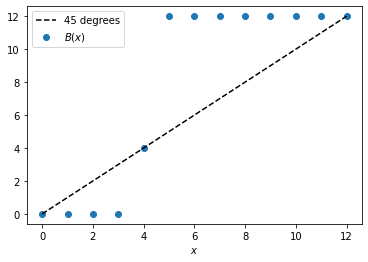

In [19]:
fig, ax = plt.subplots()
state = np.arange(0, N+1)
ax.plot(state, state, 'k--', label='45 degrees') 
ax.scatter(state, [B(x) for x in state], label='$B(x)$')
ax.legend()
ax.set_xlabel('$x$')
# plt.savefig("os_rewards.pdf")
plt.show()

Now we barplot the fraction of time sample paths spend at $N$ as epsilon varies.

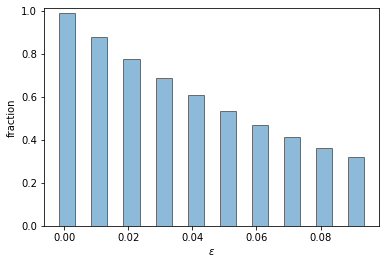

In [20]:
@jit
def compute_time_at_state(s, epsilon, sim_length=1_000_000, x_init=5):
    X = x_init
    counter = 0
    for t in range(sim_length):
        X = update(X, epsilon)
        if X == s:
            counter += 1
    return counter / sim_length

epsilons = np.arange(0.001, 0.1, step=0.01)
sample_frac = np.empty(len(epsilons))
for i, eps in enumerate(epsilons): 
    sample_frac[i] = compute_time_at_state(N, eps)

fig, ax = plt.subplots()
ax.bar(epsilons, sample_frac, width=0.005, edgecolor='k', alpha=0.5)
ax.set_ylim(0, 1.01)
ax.set_xlabel('$\\epsilon$')
ax.set_ylabel('fraction')
#plt.savefig("mutation_ess.pdf")
plt.show()
